In [1]:
import os 
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-bb1ccb6e-2bc9-c7a1-b25d-3eef9033e192/6/0"

In [2]:
"""
This requires torchtext
"""
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from pytorch_ood.dataset.txt import NewsGroup20, Reuters52, WMT16Sentences, Multi30k
from pytorch_ood.model.gruclf import GRUClassifier
from pytorch_ood.utils import ToUnknown, OODMetrics
from pytorch_ood.detector import MaxSoftmax, EnergyBased
import torch.nn.functional as F
from pytorch_ood.loss import OutlierExposureLoss

torch.manual_seed(123)

n_epochs = 10
lr = 0.001

In [3]:
# download datasets
train_dataset = NewsGroup20("data/", train=True, download=True)
test_dataset = NewsGroup20("data/", train=False, download=True)

In [4]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset)) # , max_tokens=10000# , specials=["<unk>"]
# vocab.set_default_index(0)

11293lines [00:00, 15251.65lines/s]


In [5]:
from torch.utils.data import Dataset

class MyDataset():
    def __init__(self, file, transform=None, target_transform=None):
        with open(file, 'r') as f:
            self.data = f.readlines() 
        
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, key):
        x = self.data[key]
        y = 0
        
        if self.transform:
            x = self.transform(x)
            
        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y

In [6]:
# add padding, etc.
def collate_batch(batch):
    texts = [i[0] for i in batch]
    labels = torch.tensor([i[1] for i in batch],  dtype=torch.int64)
    t_lengths = torch.tensor([len(t) for t in texts])
    max_t_length = torch.max(t_lengths)

    padded = []
    for text in texts:
        t = torch.cat([torch.zeros(max_t_length-len(text), dtype=torch.long), text])
        padded.append(t)
    return torch.stack(padded,dim=0), labels

In [7]:
def test(model, dataset, dataset_name):
    test_loader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=collate_batch)
    metrics = OODMetrics()
    metrics_energy = OODMetrics()
    softmax = MaxSoftmax(model)
    energy = EnergyBased(model)
    model.eval()

    with torch.no_grad():
        for n, batch in enumerate(test_loader):
            inputs, labels = batch

            inputs = inputs.cuda()
            labels = labels.cuda()
            metrics.update(softmax(inputs), labels)
            metrics_energy.update(energy(inputs), labels)

    d1 = metrics.compute()
    d1.update({"Method": "Softmax", "Dataset": dataset_name})
    
    d2 = metrics_energy.compute()
    d2.update({"Method": "Energy", "Dataset": dataset_name})
    return [d1, d2]

In [12]:
import pandas as pd 

dfs = []

for temp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 
                 2,3,4,5,6,7,8,9,10]:
    print(f"Temperature {temp}")
    
    for trial in range(5):
        model = GRUClassifier(num_classes=20, n_vocab=len(vocab))
        model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

        def prep(x):
            return torch.tensor([vocab[v] for v in tokenizer(x)], dtype=torch.int64)

        train_in_dataset = NewsGroup20("data/", train=True, transform=prep)
        test_dataset = NewsGroup20("data/", train=False, transform=prep)

        file = f"/data_slow/kirchheim/gan_oe/text-generation/work_language_model/generated-{temp}.txt"
        train_out_dataset = MyDataset(file=file, transform=prep, target_transform=ToUnknown()) 

        train_loader = DataLoader(train_in_dataset + train_out_dataset, batch_size=32, shuffle=True, 
                                  collate_fn=collate_batch)
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=collate_batch)


        model.train()
        model.cuda()

        criterion = OutlierExposureLoss(alpha=0.5)


        for epoch in range(n_epochs):
            # print(f"Epoch {epoch}")
            loss_ema = 0
            correct = 0
            total = 0

            model.train()
            for n, batch in enumerate(train_loader):
                inputs, labels = batch

                inputs = inputs.cuda()
                labels = labels.cuda()
                logits = model(inputs)
                loss = criterion(logits, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_ema = loss_ema * 0.9 + loss.data.cpu().numpy() * 0.1

                pred = logits.max(dim=1).indices
                correct += pred.eq(labels).sum().data.cpu().numpy()
                total += pred.shape[0]

            with torch.no_grad():
                model.eval()
                correct = 0
                total = 0
                for n, batch in enumerate(test_loader):
                    inputs, labels = batch

                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    logits = model(inputs)
                    pred = logits.max(dim=1).indices
                    correct += pred.eq(labels).sum().data.cpu().numpy()
                    total += pred.shape[0]

                # print(f"Loss {loss_ema:.2f} Test Accuracy: {correct/total:.2%}")

        res = []

        ood_dataset = Reuters52("data/", train=False, download=True, transform=prep, target_transform=ToUnknown())
        res+= test(model, test_dataset + ood_dataset, dataset_name="Reuters52")

        ood_dataset = Multi30k("data/", train=False, download=True, transform=prep, target_transform=ToUnknown())
        res+= test(model, test_dataset + ood_dataset, dataset_name="Multi30k")

        ood_dataset = WMT16Sentences("data/", download=True, transform=prep, target_transform=ToUnknown())
        res+= test(model, test_dataset + ood_dataset, dataset_name="WMT16Sentences")

        df = pd.DataFrame(res)
        df["Temperature"] = temp
        df["Trial"] = trial 
        dfs.append(df)

Temperature 0.1


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

Temperature 0.2
Temperature 0.3
Temperature 0.4
Temperature 0.5
Temperature 0.6
Temperature 0.7
Temperature 0.8
Temperature 0.9
Temperature 1
Temperature 1.1
Temperature 1.2
Temperature 1.3
Temperature 1.4
Temperature 1.5
Temperature 1.6
Temperature 1.7
Temperature 1.8
Temperature 1.9
Temperature 2
Temperature 3
Temperature 4
Temperature 5
Temperature 6
Temperature 7
Temperature 8
Temperature 9
Temperature 10


In [33]:
pd.concat(dfs).to_csv("results/text-auroc-vs-temperature.csv")

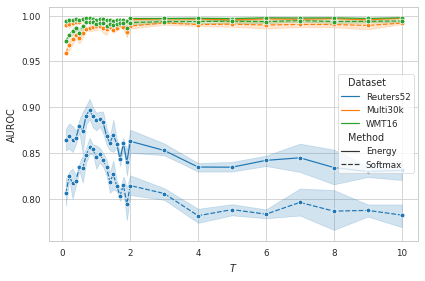

In [47]:
import seaborn as sb 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['pgf.texsystem'] = "pdflatex"

sb.set_style("whitegrid")
sb.set_context("paper")

d = pd.concat(dfs).reset_index()
d["$T$"] = d["Temperature"]

def a(x):
    if x == "WMT16Sentences":
        return "WMT16"
    else:
        return x

d["Dataset"] = d["Dataset"].apply(a)

# d = pd.concat(dfs).groupby(["Temperature", "Method", "Trial"]).mean()
g = sb.lineplot(data=d, y="AUROC", hue="Dataset", x="$T$", marker="o", style="Method", 
            style_order=["Energy", "Softmax"])

# plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"img/text-auroc-vs-temperature-detail.png", dpi=300)
plt.savefig(f"img/text-auroc-vs-temperature-detail.pgf", dpi=300)

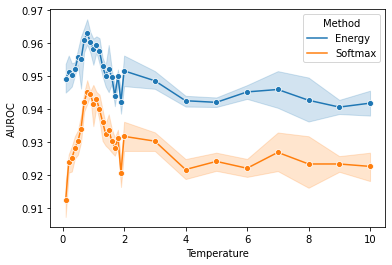

In [26]:
sb.lineplot(data=pd.concat(dfs).groupby(["Temperature", "Method", "Trial"]).mean(), 
            y="AUROC", x="Temperature", marker="o", hue="Method")
plt.savefig(f"img/text-auroc-vs-temperature.png", dpi=300)
plt.savefig(f"img/text-auroc-vs-temperature.pgf", dpi=300)

In [58]:
d = pd.concat(dfs)
d = d[(d["Temperature"] == 2.0) & (d["Trial"] == 0)]
print((d.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Temperature &  Trial \\
Method  &        &          &           &           &           &              &        \\
\midrule
Energy  &  95.11 &    87.12 &     98.03 &     85.21 &     17.50 &       200.00 &   0.00 \\
Softmax &  93.02 &    84.92 &     96.89 &     81.51 &     22.55 &       200.00 &   0.00 \\
\bottomrule
\end{tabular}

